In [254]:
from statistics import mean
from tkinter import Y
import pandas as pd
import numpy as np
from scipy import interpolate
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import iqr

In [255]:
data = pd.read_csv("Granite1.csv")

X = data[[" X", " Y", " Hardness(GPa)", " Modulus"]]
tempdf = X.copy()
print(tempdf)

            X         Y   Hardness(GPa)      Modulus
0   -4.770635  0.002520        0.441080    23.447915
1   -4.271583  0.002520        1.569489    37.284102
2   -3.770873  0.002520        0.387642     6.648113
3   -2.771181  0.002699        1.224675    32.848149
4   -1.771469  0.002709      156.045745  1888.860122
..        ...       ...             ...          ...
97   1.228045 -8.997162       25.739224   211.007222
98   2.227500 -8.997162       42.664982   681.374523
99   3.227748 -8.997162       63.865255   362.929557
100  4.227718 -8.997162       26.693745   185.871818
101  5.228601 -8.997162       17.025402   109.235284

[102 rows x 4 columns]


Extracting Outliers

In [256]:
iqr_multiplier_hard = 1.5 * iqr(X[" Hardness(GPa)"])
third_quar_hard = np.percentile(X[" Hardness(GPa)"], 75)
first_quar_hard = np.percentile(X[" Hardness(GPa)"], 25)
iqr_multiplier_mod = 1.5 * iqr(X[" Modulus"])
third_quar_mod = np.percentile(X[" Modulus"], 75)
first_quar_mod = np.percentile(X[" Modulus"], 25)

outliers = pd.DataFrame(columns=["X","Y","Hardness","Modulus","Index"])

for x in range(len(X[" Hardness(GPa)"])):
    if tempdf[" Hardness(GPa)"][x] > (iqr_multiplier_hard + third_quar_hard) or tempdf[" Hardness(GPa)"][x] < (first_quar_hard - iqr_multiplier_hard):
        outliers.loc[len(outliers.index)] = [float(X[" X"][x]), float(X[" Y"][x]), float(X[" Hardness(GPa)"][x]), float(X[" Modulus"][x]),x]
        tempdf.drop(index=x, inplace=True,axis=0)
    else:
        if tempdf[" Modulus"][x] > (iqr_multiplier_mod + third_quar_mod) or tempdf[" Modulus"][x] < (first_quar_mod - iqr_multiplier_mod):
            tempdf.drop(index=x,inplace=True)
            outliers.loc[len(outliers.index)] = [X[" X"][x], X[" Y"][x], X[" Hardness(GPa)"][x], X[" Modulus"][x], x]

print(tempdf)

            X         Y   Hardness(GPa)     Modulus
0   -4.770635  0.002520        0.441080   23.447915
1   -4.271583  0.002520        1.569489   37.284102
2   -3.770873  0.002520        0.387642    6.648113
3   -2.771181  0.002699        1.224675   32.848149
5   -0.771161  0.002709        1.841265   37.080645
..        ...       ...             ...         ...
95  -0.772362 -8.997162        1.558437   36.868433
96   0.228115 -8.997162        3.924556   50.236115
97   1.228045 -8.997162       25.739224  211.007222
100  4.227718 -8.997162       26.693745  185.871818
101  5.228601 -8.997162       17.025402  109.235284

[93 rows x 4 columns]


Interpolate Outliers

In [257]:
#linear interpolation
for i in range(len(outliers)):
    hard_new = outliers["Hardness"][i]
    mod_new = outliers["Modulus"][i]
    if outliers["Hardness"][i] > (iqr_multiplier_hard + third_quar_hard) or outliers["Hardness"][i] < (first_quar_hard - iqr_multiplier_hard):
        o_l = tempdf.loc[round(tempdf[" Y"], 2) == round(outliers["Y"][i], 2)]
        hard_interp = interpolate.interp1d(o_l[" X"], o_l[" Hardness(GPa)"], kind="linear", fill_value="extrapolate")
        hard_new = hard_interp(outliers["X"][i])
    if outliers["Modulus"][i] > (iqr_multiplier_mod + third_quar_mod) or outliers["Modulus"][i] < (first_quar_mod - iqr_multiplier_mod):
        o_l = tempdf.loc[round(tempdf[" Y"], 2) == round(outliers["Y"][i], 2)]
        mod_interp = interpolate.interp1d(o_l[" X"], o_l[" Modulus"], kind="linear", fill_value="extrapolate")
        mod_new = mod_interp(outliers["X"][i])
    tempdf.loc[outliers["Index"][i]] = [outliers["X"][i], outliers["Y"][i], hard_new, mod_new]

print(tempdf)

             X         Y       Hardness(GPa)             Modulus
0.0  -4.770635  0.002520             0.44108           23.447915
1.0  -4.271583  0.002520            1.569489           37.284102
2.0  -3.770873  0.002520            0.387642            6.648113
3.0  -2.771181  0.002699            1.224675           32.848149
5.0  -0.771161  0.002709            1.841265           37.080645
...        ...       ...                 ...                 ...
74.0 -1.771588 -6.996855   7.602633237804616  187.81701844488663
82.0 -3.770764 -7.997073  39.317826574992836          292.182908
90.0  4.227797 -7.997093  1.2663065944321295  39.298832853134776
98.0  2.227500 -8.997162           42.664982   202.6324120797797
99.0  3.227748 -8.997162  34.678254357339085          362.929557

[102 rows x 4 columns]


Data Normalization

In [258]:
max_hard = max(tempdf[" Hardness(GPa)"])
min_hard = min(tempdf[" Hardness(GPa)"])
max_mod =  max(tempdf[" Modulus"])
min_mod = min(tempdf[" Modulus"])
max_x = max(tempdf[" X"])
min_x = min(tempdf[" X"])
max_y = max(tempdf[" Y"])
min_y = min(tempdf[" Y"])

for x in range(len(tempdf)):
    tempdf[" Hardness(GPa)"][x] = (tempdf[" Hardness(GPa)"][x]-min_hard)/(max_hard-min_hard)
    tempdf[" Modulus"][x] = (tempdf[" Modulus"][x]-min_mod)/(max_mod-min_mod)
    if round((tempdf[" Y"][x]-min_y)/(max_y-min_y), 2)==.99:
        tempdf[" Y"][x] = 1
    else:
        tempdf[" Y"][x] = round((tempdf[" Y"][x]-min_y)/(max_y-min_y), 2)
    tempdf[" X"][x] = round((tempdf[" X"][x]-min_x)/(max_x-min_x), 2)

print(tempdf)

         X     Y  Hardness(GPa)   Modulus
0.0   0.00  1.00       0.176731  0.304204
1.0   0.05  1.00       0.195486  0.332562
2.0   0.10  1.00       0.175843  0.269771
3.0   0.20  1.00       0.189755   0.32347
5.0   0.40  1.00       0.200003  0.332145
...    ...   ...            ...       ...
74.0  0.30  0.22       0.295758  0.641092
82.0  0.10  0.11        0.82287  0.854999
90.0  0.90  0.11       0.190447  0.336692
98.0  0.70  0.00       0.878501  0.671457
99.0  0.80  0.00        0.74576       1.0

[102 rows x 4 columns]


/var/folders/9g/pn4nc72540zbw3dkklz1ddl00000gn/T/ipykernel_93410/3427144755.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf[" Hardness(GPa)"][x] = (tempdf[" Hardness(GPa)"][x]-min_hard)/(max_hard-min_hard)
/var/folders/9g/pn4nc72540zbw3dkklz1ddl00000gn/T/ipykernel_93410/3427144755.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempdf[" Modulus"][x] = (tempdf[" Modulus"][x]-min_mod)/(max_mod-min_mod)
/var/folders/9g/pn4nc72540zbw3dkklz1ddl00000gn/T/ipykernel_93410/3427144755.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documen

Add Data Points

In [259]:
#add data points
tempdf = tempdf.drop([0,1])

x = np.linspace(.1, 1, 10)
y = np.linspace(0, 1, 10)
xx,yy = np.meshgrid(x,y)
z_h = tempdf[" Hardness(GPa)"].to_numpy().reshape([10,10])
z_m = tempdf[" Modulus"].to_numpy().reshape([10,10])

hard_interp_norm=interpolate.interp2d(x, y, z_h, kind="linear")
mod_interp_norm=interpolate.interp2d(x, y, z_m, kind="linear")

In [260]:
new_temp = pd.DataFrame()
pts = 20
feature_x = np.linspace(.1, 1, pts)
feature_y = np.linspace(0, 1, pts)


new_temp["X"] = list(feature_x) * pts
arr = []
for i in list(feature_y):
    arr.append([i]*pts)
new_temp["Y"] = np.array(arr).reshape([pts*pts, 1])

feature_hard = hard_interp_norm(feature_x, feature_y).reshape([pts*pts,1])
feature_mod = mod_interp_norm(feature_x, feature_y).reshape([pts*pts,1])
feature_hard = [i[0] for i in feature_hard]
feature_mod = [i[0] for i in feature_mod]

new_temp["Hardness"] = feature_hard
new_temp["Modulus"] = feature_mod

K-Means Clustering

<bound method NDFrame.head of             X    Y  Hardness   Modulus  Cluster
0    0.100000  0.0  0.175843  0.269771        3
1    0.147368  0.0  0.182433  0.295208        3
2    0.194737  0.0  0.189023  0.320644        3
3    0.242105  0.0  0.194070  0.327123        3
4    0.289474  0.0  0.198924  0.331232        3
..        ...  ...       ...       ...      ...
395  0.810526  1.0  0.262873  0.371930        2
396  0.857895  1.0  0.588794  0.530503        2
397  0.905263  1.0  0.871514  0.688749        2
398  0.952632  1.0  0.808637  0.844375        2
399  1.000000  1.0  0.745760  1.000000        2

[400 rows x 5 columns]>


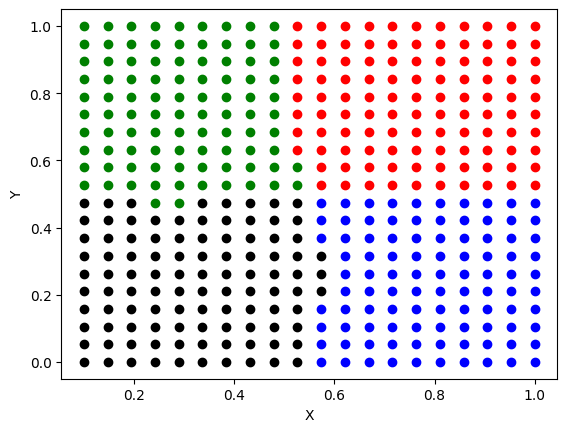

In [261]:
#kmeans
km = KMeans(n_clusters = 4, init="k-means++",max_iter=300,n_init=10,random_state=0)
km.fit(new_temp)
clusters = km.predict(new_temp)
new_temp["Cluster"]=clusters
print(new_temp.head)

color=["blue", "green", "red", "black"]

for i in range(len(new_temp)):
    plt.scatter(new_temp["X"][i], new_temp["Y"][i], c = color[new_temp["Cluster"][i]])
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Contour Map

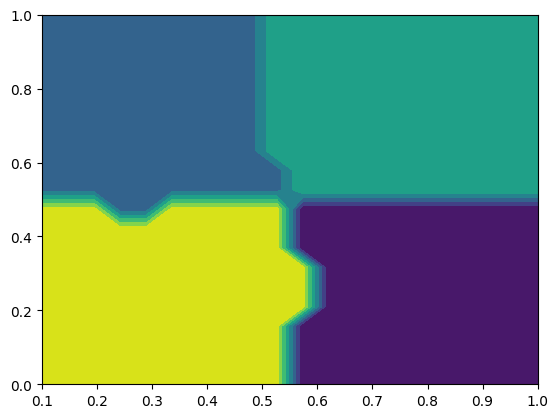

In [262]:
z_cluster = new_temp["Cluster"].to_numpy().reshape([pts,pts])

fig,ax = plt.subplots(1,1)
ax.contourf(feature_x, feature_y, z_cluster)
plt.show()